## 3. Network models

With the neuron and synapse models we have realized with BrainPy, users can now build networks of there own. In this section, we will introduce two main types of network models as examples: 1) spiking neural networks that model and compute each neuron or synapse separately; 2) firing rate networks that simplify neuron groups in the network as firing rate units and compute each neuron group as one unit.

### 3.1 Spiking Neural Network

#### 3.1.1 E/I balanced network

In 1990s, biologists found in experiments that neuron activities in brain cortex show a temporal irregular spiking pattern. This pattern exists widely in brain areas, but researchers knew few about the mechanism and function of it.

Vreeswijk and Sompolinsky (1996) proposed E/I balanced network to explain this irregular spiking pattern. The feature of this network is the strong, random and sparse synapse connections between neurons. Because of this feature and corresponding parameter settings, each neuron in the network will receive great excitatory and inhibitory input from within the network, but these two types of input will cancel each other, and maintain the total internal input at a relatively small order of magnitude, which is only enough to generate action potentials.

The randomness and noise in E/I balanced network give an internal input which varies with time and space at the order of threshold potential to each neuron in the network. Therefore, the firing of neurons also has randomness,  ensures that E/I balanced network can generate temporal irregular firing pattern spontaneously.

Vreeswijk and Sompolinsky also suggested a possible function of this irregular firing pattern: E/I balanced network can respond to the changes of external stimulus quickly.

When there is no external input, the distribution of neurons’ membrane potentials in E/I balanced network follows a relatively uniform random distribution between resting potential and threshold potential.

When we give the network a small constant external stimulus, there are always some neurons whose membrane potentials fall near the threshold potential. Turn the stimulus on and these neurons will soon meet the threshold, therefore spike rapidly. On the network scale, the firing rate of neurons in the network can adjust rapidly once the input changes.

Simulation suggests that the delay of network response to input is the same order of magnitude as synapse delay, and is significantly less than the delay of a single neuron that facing the same stimulus at resting potential generates a spike.

As a result, we say E/I balanced network may provide a fast response mechanism for neural networks. 

<img src="../images/brainpy_tutorials/3-2.png">
<center><b>Fig.3-2 Structure of E/I balanced network</b></center>

Fig. 3-2 shows the structure of E/I balanced network:

1)	Neurons: LIF neurons are used in the network. The neurons can be divided into excitatory neurons and inhibitory neurons, the number of two types of neurons are $N_E$: $N_I$ = 4:1.

    neu_E = LIF(N_E, monitors = ['spike'])
    neu_I = LIF(N_I, monitors = ['spike'])
    neu_E.V = V_rest + np.random.random(N_E) * (V_th - V_rest)
    neu_I.V = V_rest + np.random.random(N_I) * (V_th - V_rest)

2)	Synapses: Exponential synapses are used in the network. 4 groups of synapse connections are generated between the two groups of neurons, that is, excitatory-excitatory connection (E2E conn), excitatory-inhibitory connection (E2I conn), inhibitory-excitatory connection (I2E conn) and inhibitory-inhibitory connection (I2I conn). To express the excitatory or inhibitory of the synapse connections, we define synapse weight with different signal.

    syn_E2E = Syn(pre = neu_E, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
    syn_E2I = Syn(pre = neu_E, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
    syn_I2E = Syn(pre = neu_I, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
    syn_I2I = Syn(pre = neu_I, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
    syn_E2E.w = JE
    syn_E2I.w = JE
    syn_I2E.w = -JI
    syn_I2I.w = -JI

3)	Inputs: All neurons in the network receive a constant input current from outside of network.

    net.run(500., inputs = [(neu_E, 'input', 3.), (neu_I, 'input', 3.)], report = True)

See above section 1 and 2 for definition of LIF neuron class and Exponential synapse class. Visualize the simulation result of E/I balanced network, the network firing rate changes from strong synchronization to irregular fluctuation.

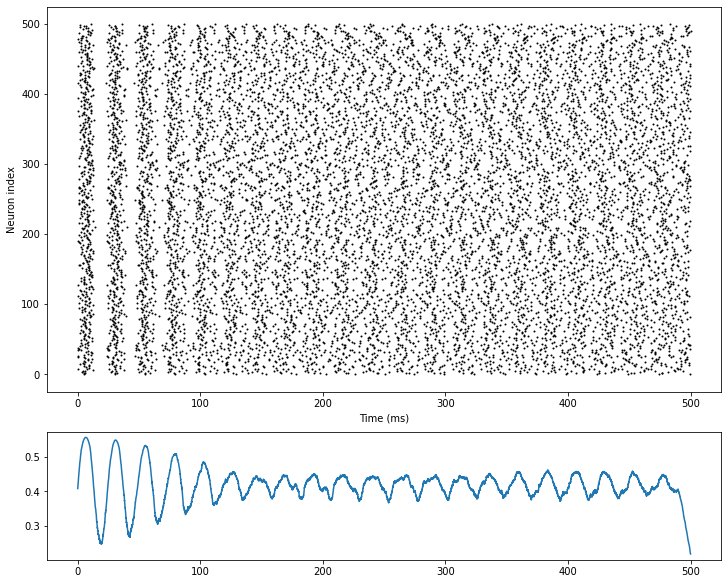

In [54]:
import brainpy as bp
import matplotlib.pyplot as plt
import numpy as np
from numba import prange

bp.backend.set('numba')

N_E = 500
N_I = 500
prob = 0.1

tau = 10.
V_rest = -52.
V_reset = -60.
V_th = -50.

class LIF(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, V_rest = V_rest, V_reset = V_reset,
                 V_th = V_th, tau = tau, **kwargs):
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.tau = tau

        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype = bool)

        super(LIF, self).__init__(size = size, **kwargs)

    @staticmethod
    @bp.odeint
    def integral(V, t, I_ext, V_rest, tau):
        return (-V + V_rest + I_ext) / tau

    def update(self, _t):
        V = self.integral(self.V, _t, self.input, self.V_rest, self.tau)
        sp = V > self.V_th
        V[sp] = self.V_reset
        self.V = V
        self.spike = sp
        self.input[:] = 0.

tau_decay = 2.
JE = 1 / np.sqrt(prob * N_E)
JI = 1 / np.sqrt(prob * N_I)

class Syn(bp.TwoEndConn):
    target_backend = 'general'

    def __init__(self, pre, post, conn,
                 tau_decay = tau_decay, w = 0., 
                 **kwargs):
        self.tau_decay = tau_decay
        self.w = w

        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.size = len(self.pre_ids)

        self.s = bp.ops.zeros(self.size)
        self.g = bp.ops.zeros(self.size)

        super(Syn, self).__init__(pre = pre, post = post, **kwargs)
    
    @staticmethod
    @bp.odeint(method = 'rk4')
    def integral(s, t, tau):
        return -s / tau

    def update(self, _t):
        for i in prange(self.size):
            self.s[i] = self.integral(self.s[i], _t, self.tau_decay)
            pre_id = self.pre_ids[i]
            self.s[i] += self.pre.spike[pre_id]
            g = self.w * self.s[i]
            post_id = self.post_ids[i]
            self.post.input[post_id] += g

neu_E = LIF(N_E, monitors = ['spike'])
neu_I = LIF(N_I, monitors = ['spike'])
neu_E.V = V_rest + np.random.random(N_E) * (V_th - V_rest)
neu_I.V = V_rest + np.random.random(N_I) * (V_th - V_rest)

syn_E2E = Syn(pre = neu_E, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
syn_E2I = Syn(pre = neu_E, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
syn_I2E = Syn(pre = neu_I, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
syn_I2I = Syn(pre = neu_I, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
syn_E2E.w = JE
syn_E2I.w = JE
syn_I2E.w = -JI
syn_I2I.w = -JI

net = bp.Network(neu_E, neu_I, 
                 syn_E2E, syn_E2I, 
                 syn_I2E, syn_I2I)
net.run(500., inputs = [(neu_E, 'input', 3.), (neu_I, 'input', 3.)])


fig, gs = bp.visualize.get_figure(4, 1, 2, 10)
fig.add_subplot(gs[:3, 0])
bp.visualization.raster_plot(net.ts, neu_E.mon.spike)

fig.add_subplot(gs[3, 0])
rate = bp.measure.firing_rate(neu_E.mon.spike, 5.)
plt.plot(net.ts, rate)
plt.show()

<center><b>Fig.3-3 E/I balanced net raster plot</b></center>

#### 3.1.2 Decision Making Network

The modeling of computational neuroscience networks can correspond to specific physiological tasks, like the visual motion discrimination task (Roitman and Shadlen, 2002). In this task, rhesus watch a video in which random dots move towards left or right with definite coherence. Rhesus are required to choose the direction that most dots move to and give their answer by saccade. At the meantime, researchers record the activity of their LIF neurons by implanted electrode.

<img src="../images/brainpy_tutorials/3-4.png"> 
<center><b>Fig.3-4 Experimental Disgram</b></center>

Wang (2002) proposed a decision making network to model the activity of rhesus LIF neurons during decision making period. As shown in Fig. 3-5, this network is based on E/I balanced network, with excitatory neuron and inhibitory neuron number in the proportion 4:1, and maintain the balanced state by adjusting parameters.

Among the excitatory neuron group, two selective subgroup are chosen, both with a size of 0.15 * N_E. These two subgroups are marked as A and B in Fig. 3-5. Other excitatory neuron are non-selective.

<img src="../images/brainpy_tutorials/3-5.png">
<center><b>Fig.3-5 structure of decision makingnetwork</b></center>

    # def E neurons/pyramid neurons
    neu_A = LIF(N_A, monitors=['spike', 'input', 'V'])
    neu_B = LIF(N_B, monitors=['spike', 'input', 'V'])
    neu_non = LIF(N_non, monitors=['spike', 'input', 'V'])
    # def I neurons/interneurons
    neu_I = LIF(N_I, monitors=['input', 'V'])

As it is in E/I balanced network, synapses can be classified into E2E connection, E2I connection, I2E connection and I2I connection. Excitatory connections are realized with AMPA synapse, inhibitory connections are realized with GABAa synapse. In order to force the network to make decisions between group A and group B, E2E connections are structured. As shown in Sheet 3-1, the strength of synapse connections is higher in the same selective subgroup, and lower between two subgroups or between selective and non-selective subgroup.

<center><b>Sheet 3-1 Weight of synapse connections between E-neurons</b></center>
<img src="../images/brainpy_tutorials/3-6.png">

    syn_A2A_AMPA = AMPA(pre=neu_A, post=neu_A,
                  conn=bp.connect.All2All(),
                  delay=delay_syn)
    syn_A2A_AMPA.g_max = g_max_E2E_AMPA * w_pos

    syn_A2B_AMPA = AMPA(pre=neu_A, post=neu_B,
                  conn=bp.connect.All2All(),
                  delay=delay_syn)
    syn_A2B_AMPA.g_max = g_max_E2E_AMPA * w_neg

    syn_A2non_AMPA = AMPA(pre=neu_A, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
    syn_A2non_AMPA.g_max = g_max_E2E_AMPA * w_neg

    # ...

We give two types of external inputs to the decision making network: 1) Background inputs from other brain areas without specific meaning. Represented as high frequency Poisson input mediated by AMPA synapse; 2) Stimulus inputs from outside the brain, which are given only to the two selective subgroup A and B. Represented as lower frequency Poisson input mediated by AMPA synapse. To simulate the proportion difference of the dots moving to left and right in physiological experiments, the stimulus frequencies given to A and B group have a certain difference.

    neu_poisson_A = PoissonInput(N_A, freqs=poisson_freq, dt=dt)
    neu_poisson_B = PoissonInput(N_B, freqs=poisson_freq, dt=dt)
    neu_poisson_non = PoissonInput(N_non, freqs=poisson_freq, dt=dt)
    neu_poisson_I = PoissonInput(N_I, freqs=poisson_freq, dt=dt)

    syn_back2A_AMPA = AMPA(pre=neu_poisson_A, post=neu_A,
                    conn=bp.connect.One2One())
    syn_back2B_AMPA = AMPA(pre=neu_poisson_B, post=neu_B,
                    conn=bp.connect.One2One())
    syn_back2non_AMPA = AMPA(pre=neu_poisson_non, post=neu_non,
                     conn=bp.connect.One2One())

During the simulation, group A receive a larger stimulus input than group B (i.e. more random dot move to the direction represented by A), later, considerable differentiation are found between the population activities of the two selective subgroups. In this example, the activity of group A is higher than group B, which means, the network choose the right direction receives higher stimulus.

N_E = 320 = 48 + 48 + 224, N_I = 80
R_E * C_E = 20.0 should be equal to tau_E = 20.0
R_I * C_I = 10.0 should be equal to tau_I = 10.0
the structured weight is: w_pos = 1.7, w_neg = 0.8764705882352941
Check contraints: Weight sum 319.9999999999997         should be equal to N_E = 320
coherence = 25.6, mu_A = 50.24, mu_B = 29.759999999999998
Compilation used 0.0157 s.
Start running ...
Run 10.0% used 11.862 s.
Run 20.0% used 22.960 s.
Run 30.0% used 34.160 s.
Run 40.0% used 45.790 s.
Run 50.0% used 57.161 s.
Run 60.0% used 68.416 s.
Run 70.0% used 79.667 s.
Run 80.0% used 91.376 s.
Run 90.0% used 102.714 s.
Run 100.0% used 113.894 s.
Simulation is done in 113.894 s.

computing fr...
get fr


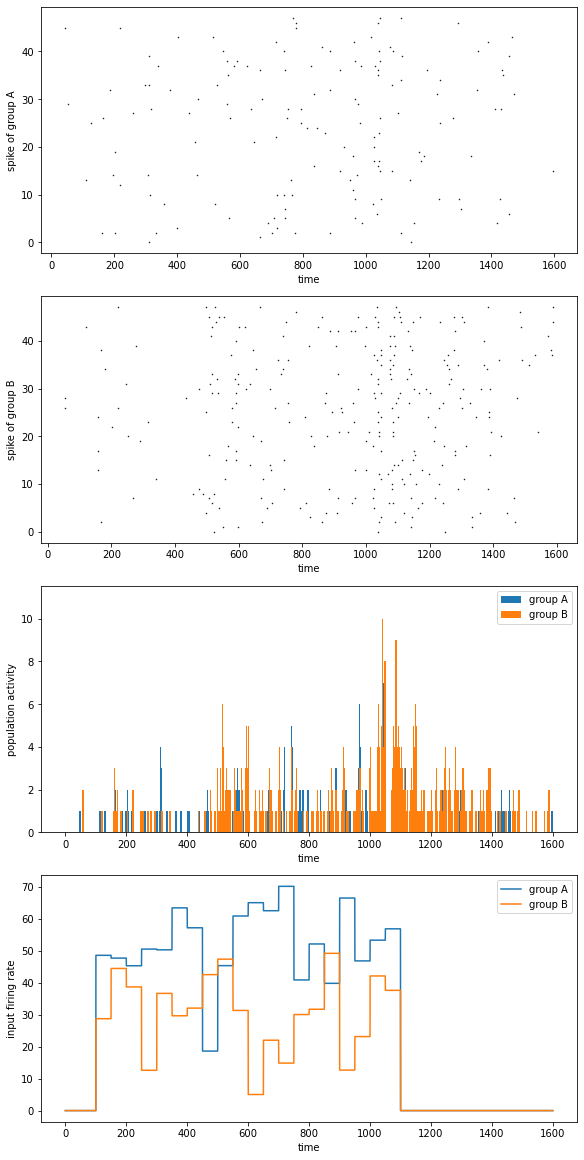

In [1]:
"""
Implementation of the paper:

Wang, Xiao-Jing. "Probabilistic decision making by slow 
reverberation in cortical circuits." Neuron 36.5 (2002): 955-968.
"""
import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt

# set params
# set global params
dt = 0.05  # ms
method = 'exponential'
bp.backend.set('numpy', dt=dt)

# set network params
base_N_E = 1600
base_N_I = 400
net_scale = 5.
N_E = int(base_N_E // net_scale)
N_I = int(base_N_I // net_scale)

f = 0.15  # Note: proportion of neurons activated by one of the two stimulus
N_A = int(f * N_E)
N_B = int(f * N_E)
N_non = N_E - N_A - N_B  # Note: N_E = N_A + N_B + N_non
print(f"N_E = {N_E} = {N_A} + {N_B} + {N_non}, N_I = {N_I}")
# Note: N_E[0:N_A]: A_group
#       N_E[N_A : N_A+N_B]: B_group
#       N_E[N_A + N_B: N_E]: non of A or B

time_scale = 1.
pre_period = 100. / time_scale
stim_period = 1000.
delay_period = 500. / time_scale
total_period = pre_period + stim_period + delay_period

# set LIF neu params
V_rest_E = -70.  # mV
V_reset_E = -55.  # mV
V_th_E = -50.  # mV
g_E = 25. * 1e-3  # uS
R_E = 1 / g_E  # MOhm
C_E = 0.5  # nF
tau_E = 20.  # ms
t_refractory_E = 2.  # ms
print(f"R_E * C_E = {R_E * C_E} should be equal to tau_E = {tau_E}")

V_rest_I = -70.  # mV
V_reset_I = -55.  # mV
V_th_I = -50.  # mV
g_I = 20. * 1e-3  # uS
R_I = 1 / g_I  # Mohm
C_I = 0.2  # nF
tau_I = 10.  # ms
t_refractory_I = 1.  # ms
print(f"R_I * C_I = {R_I * C_I} should be equal to tau_I = {tau_I}")


class LIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, R, tau):
        dvdt = (- (V - V_rest) + R * I_ext) / tau
        return dvdt

    def __init__(self, size, V_rest=0., V_reset=0.,
                 V_th=0., R=0., tau=0., t_refractory=0.,
                 **kwargs):
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)
        self.refractory = bp.ops.zeros(size, dtype=bool)
        self.t_last_spike = bp.ops.ones(size) * -1e7

        self.integral = bp.odeint(self.derivative)
        super(LIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        # update variables
        not_ref = (_t - self.t_last_spike > self.t_refractory)
        self.V[not_ref] = self.integral(
            self.V[not_ref], _t, self.input[not_ref],
            self.V_rest, self.R, self.tau)
        sp = (self.V > self.V_th)
        self.V[sp] = self.V_reset
        self.t_last_spike[sp] = _t
        self.spike = sp
        self.refractory = ~not_ref
        self.input[:] = 0.


# set syn params
E_AMPA = 0.  # mV
tau_decay_AMPA = 2  # ms

E_NMDA = 0.  # mV
alpha_NMDA = 0.062  # \
beta_NMDA = 3.57  # \
cc_Mg_NMDA = 1.  # mM
a_NMDA = 0.5  # kHz/ms^-1
tau_rise_NMDA = 2.  # ms
tau_decay_NMDA = 100.  # ms

E_GABAa = -70.  # mV
tau_decay_GABAa = 5.  # ms

delay_syn = 0.5  # ms


class NMDA(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau_rise, tau_decay, a):
        dxdt = -x / tau_rise
        dsdt = -s / tau_decay + a * x * (1 - s)
        return dsdt, dxdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.15, E=0., cc_Mg=1.2,
                 alpha=0.062, beta=3.57, tau=100,
                 a=0.5, tau_rise=2., **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.cc_Mg = cc_Mg
        self.tau = tau
        self.tau_rise = tau_rise
        self.a = a
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.x = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(NMDA, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.x += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.s, self.x = self.integral(self.s, self.x, _t,
                                       self.tau_rise, self.tau, self.a)

        self.g.push(self.g_max * self.s)
        g_inf = 1 + self.cc_Mg / self.beta * \
                bp.ops.exp(-self.alpha * self.post.V)
        g_inf = 1 / g_inf
        self.post.input -= bp.ops.sum(self.g.pull(), axis=0) * \
                           (self.post.V - self.E) * g_inf


class AMPA(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau):
        ds = - s / tau
        return ds

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.int_s = bp.odeint(f=self.derivative, method='euler')
        super(AMPA, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.int_s(self.s, _t, self.tau)
        self.s += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.g.push(self.g_max * self.s)
        self.post.input -= bp.ops.sum(self.g.pull(), 0) \
                           * (self.post.V - self.E)


class GABAa(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau_decay):
        dsdt = - s / tau_decay
        return dsdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.4, E=-80., tau_decay=6.,
                 **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau_decay = tau_decay
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(GABAa, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.integral(self.s, _t, self.tau_decay)
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.s[i] += self.conn_mat[i]
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.ops.sum(g, axis=0) * (self.post.V - self.E)


# set syn weights (only used in recurrent E connections)
w_pos = 1.7
w_neg = 1. - f * (w_pos - 1.) / (1. - f)
print(f"the structured weight is: w_pos = {w_pos}, w_neg = {w_neg}")
# inside select group: w = w+
# between group / from non-select group to select group: w = w-
# A2A B2B w+, A2B B2A w-, non2A non2B w-
weight = np.ones((N_E, N_E), dtype=np.float)
for i in range(N_A):
    weight[i, 0: N_A] = w_pos
    weight[i, N_A: N_A + N_B] = w_neg
for i in range(N_A, N_A + N_B):
    weight[i, N_A: N_A + N_B] = w_pos
    weight[i, 0: N_A] = w_neg
for i in range(N_A + N_B, N_E):
    weight[i, 0: N_A + N_B] = w_neg
print(f"Check contraints: Weight sum {weight.sum(axis=0)[0]} \
        should be equal to N_E = {N_E}")

# set background params
poisson_freq = 2400.  # Hz
g_max_ext2E_AMPA = 2.1 * 1e-3  # uS
g_max_ext2I_AMPA = 1.62 * 1e-3  # uS

g_max_E2E_AMPA = 0.05 * 1e-3 * net_scale
g_max_E2E_NMDA = 0.165 * 1e-3 * net_scale
g_max_E2I_AMPA = 0.04 * 1e-3 * net_scale
g_max_E2I_NMDA = 0.13 * 1e-3 * net_scale
g_max_I2E_GABAa = 1.3 * 1e-3 * net_scale
g_max_I2I_GABAa = 1.0 * 1e-3 * net_scale

# def neurons
# def E neurons/pyramid neurons
neu_A = LIF(N_A, monitors=['spike', 'input', 'V'])
neu_A.V_rest = V_rest_E
neu_A.V_reset = V_reset_E
neu_A.V_th = V_th_E
neu_A.R = R_E
neu_A.tau = tau_E
neu_A.t_refractory = t_refractory_E
neu_A.V = bp.ops.ones(N_A) * V_rest_E

neu_B = LIF(N_B, monitors=['spike', 'input', 'V'])
neu_B.V_rest = V_rest_E
neu_B.V_reset = V_reset_E
neu_B.V_th = V_th_E
neu_B.R = R_E
neu_B.tau = tau_E
neu_B.t_refractory = t_refractory_E
neu_B.V = bp.ops.ones(N_B) * V_rest_E

neu_non = LIF(N_non, monitors=['spike', 'input', 'V'])
neu_non.V_rest = V_rest_E
neu_non.V_reset = V_reset_E
neu_non.V_th = V_th_E
neu_non.R = R_E
neu_non.tau = tau_E
neu_non.t_refractory = t_refractory_E
neu_non.V = bp.ops.ones(N_non) * V_rest_E

# def I neurons/interneurons
neu_I = LIF(N_I, monitors=['input', 'V'])
neu_I.V_rest = V_rest_I
neu_I.V_reset = V_reset_I
neu_I.V_th = V_th_I
neu_I.R = R_I
neu_I.tau = tau_I
neu_I.t_refractory = t_refractory_I
neu_I.V = bp.ops.ones(N_I) * V_rest_I

# def synapse connections
## define E2E conn
syn_A2A_AMPA = AMPA(pre=neu_A, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2A_NMDA = NMDA(pre=neu_A, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_A2B_AMPA = AMPA(pre=neu_A, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2B_NMDA = NMDA(pre=neu_A, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_A2non_AMPA = AMPA(pre=neu_A, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_A2non_NMDA = NMDA(pre=neu_A, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_B2A_AMPA = AMPA(pre=neu_B, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2A_NMDA = NMDA(pre=neu_B, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_B2B_AMPA = AMPA(pre=neu_B, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2B_NMDA = NMDA(pre=neu_B, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_B2non_AMPA = AMPA(pre=neu_B, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_B2non_NMDA = NMDA(pre=neu_B, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_non2A_AMPA = AMPA(pre=neu_non, post=neu_A,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_non2A_NMDA = NMDA(pre=neu_non, post=neu_A,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_non2B_AMPA = AMPA(pre=neu_non, post=neu_B,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_non2B_NMDA = NMDA(pre=neu_non, post=neu_B,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_non2non_AMPA = AMPA(pre=neu_non, post=neu_non,
                        conn=bp.connect.All2All(),
                        delay=delay_syn)
syn_non2non_NMDA = NMDA(pre=neu_non, post=neu_non,
                        conn=bp.connect.All2All(),
                        delay=delay_syn)

syn_A2A_AMPA.g_max = g_max_E2E_AMPA * w_pos
syn_A2A_NMDA.g_max = g_max_E2E_NMDA * w_pos

syn_A2B_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_A2B_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_A2non_AMPA.g_max = g_max_E2E_AMPA
syn_A2non_NMDA.g_max = g_max_E2E_NMDA

syn_B2A_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_B2A_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_B2B_AMPA.g_max = g_max_E2E_AMPA * w_pos
syn_B2B_NMDA.g_max = g_max_E2E_NMDA * w_pos

syn_B2non_AMPA.g_max = g_max_E2E_AMPA
syn_B2non_NMDA.g_max = g_max_E2E_NMDA

syn_non2A_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_non2A_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_non2B_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_non2B_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_non2non_AMPA.g_max = g_max_E2E_AMPA
syn_non2non_NMDA.g_max = g_max_E2E_NMDA

for i in [syn_A2A_AMPA, syn_A2B_AMPA, syn_A2non_AMPA,
          syn_B2A_AMPA, syn_B2B_AMPA, syn_B2non_AMPA,
          syn_non2A_AMPA, syn_non2B_AMPA, syn_non2non_AMPA]:
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA
    i.E = E_NMDA

for i in [syn_A2A_NMDA, syn_A2B_NMDA, syn_A2non_NMDA,
          syn_B2A_NMDA, syn_B2B_NMDA, syn_B2non_NMDA,
          syn_non2A_NMDA, syn_non2B_NMDA, syn_non2non_NMDA]:
    i.alpha = alpha_NMDA
    i.beta = beta_NMDA
    i.cc_Mg = cc_Mg_NMDA
    i.a = a_NMDA
    i.tau_decay = tau_decay_NMDA
    i.tau_rise = tau_rise_NMDA

## define E2I conn
syn_A2I_AMPA = AMPA(pre=neu_A, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2I_NMDA = NMDA(pre=neu_A, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_B2I_AMPA = AMPA(pre=neu_B, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2I_NMDA = NMDA(pre=neu_B, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_non2I_AMPA = AMPA(pre=neu_non, post=neu_I,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_non2I_NMDA = NMDA(pre=neu_non, post=neu_I,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

for i in [syn_A2I_AMPA, syn_B2I_AMPA, syn_non2I_AMPA]:
    i.g_max = g_max_E2I_AMPA
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA

for i in [syn_A2I_NMDA, syn_B2I_NMDA, syn_non2I_NMDA]:
    i.g_max = g_max_E2I_NMDA
    i.E = E_NMDA
    i.alpha = alpha_NMDA
    i.beta = beta_NMDA
    i.cc_Mg = cc_Mg_NMDA
    i.a = a_NMDA
    i.tau_decay = tau_decay_NMDA
    i.tau_rise = tau_rise_NMDA

## define I2E conn
syn_I2A_GABAa = GABAa(pre=neu_I, post=neu_A,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2B_GABAa = GABAa(pre=neu_I, post=neu_B,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2non_GABAa = GABAa(pre=neu_I, post=neu_non,
                        conn=bp.connect.All2All(),
                        delay=delay_syn)
for i in [syn_I2A_GABAa, syn_I2B_GABAa, syn_I2non_GABAa]:
    i.g_max = g_max_I2E_GABAa
    i.E = E_GABAa
    i.tau_decay = tau_decay_GABAa

## define I2I conn
syn_I2I_GABAa = GABAa(pre=neu_I, post=neu_I,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2I_GABAa.g_max = g_max_I2I_GABAa
syn_I2I_GABAa.E = E_GABAa
syn_I2I_GABAa.tau_decay = tau_decay_GABAa


# def background poisson input
class PoissonInput(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, freqs, dt, **kwargs):
        self.freqs = freqs
        self.dt = dt

        self.spike = bp.ops.zeros(size, dtype=bool)

        super(PoissonInput, self).__init__(size=size, **kwargs)

    def update(self, _t):
        self.spike = np.random.random(self.size) \
                     < self.freqs * self.dt / 1000.


neu_poisson_A = PoissonInput(N_A, freqs=poisson_freq, dt=dt)
neu_poisson_B = PoissonInput(N_B, freqs=poisson_freq, dt=dt)
neu_poisson_non = PoissonInput(N_non, freqs=poisson_freq, dt=dt)
neu_poisson_I = PoissonInput(N_I, freqs=poisson_freq, dt=dt)

syn_back2A_AMPA = AMPA(pre=neu_poisson_A, post=neu_A,
                       conn=bp.connect.One2One())
syn_back2B_AMPA = AMPA(pre=neu_poisson_B, post=neu_B,
                       conn=bp.connect.One2One())
syn_back2non_AMPA = AMPA(pre=neu_poisson_non, post=neu_non,
                         conn=bp.connect.One2One())
for i in [syn_back2A_AMPA, syn_back2B_AMPA, syn_back2non_AMPA]:
    i.g_max = g_max_ext2E_AMPA
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA

syn_back2I_AMPA = AMPA(pre=neu_poisson_I, post=neu_I,
                       conn=bp.connect.One2One())
syn_back2I_AMPA.g_max = g_max_ext2I_AMPA
syn_back2I_AMPA.E = E_AMPA
syn_back2I_AMPA.tau_decay = tau_decay_AMPA
# Note: all neurons receive 2400Hz background possion inputs

## def stimulus input
# Note: inputs only given to A and B group
mu_0 = 40.
coherence = 25.6
rou_A = mu_0 / 100.
rou_B = mu_0 / 100.
mu_A = mu_0 + rou_A * coherence
mu_B = mu_0 - rou_B * coherence
print(f"coherence = {coherence}, mu_A = {mu_A}, mu_B = {mu_B}")


class PoissonStim(bp.NeuGroup):
    """
    from time <t_start> to <t_end> during the simulation, the neuron 
    generates a possion spike with frequency <self.freq>. however, 
    the value of <self.freq> changes every <t_interval> ms and obey 
    a Gaussian distribution defined by <mean_freq> and <var_freq>.
    """
    target_backend = 'general'

    def __init__(self, size, dt=0., t_start=0., t_end=0., t_interval=0.,
                 mean_freq=0., var_freq=20., **kwargs):
        self.dt = dt
        self.stim_start_t = t_start
        self.stim_end_t = t_end
        self.stim_change_freq_interval = t_interval
        self.mean_freq = mean_freq
        self.var_freq = var_freq

        self.freq = 0.
        self.t_last_change_freq = -1e7
        self.spike = bp.ops.zeros(size, dtype=bool)

        super(PoissonStim, self).__init__(size=size, **kwargs)

    def update(self, _t):
        if _t > self.stim_start_t and _t < self.stim_end_t:
            if _t - self.t_last_change_freq \
                    >= self.stim_change_freq_interval:  # change freq
                self.freq = np.random.normal(self.mean_freq, self.var_freq)
                self.freq = max(self.freq, 0)
                self.t_last_change_freq = _t
            self.spike = np.random.random(self.size) \
                         < (self.freq * self.dt / 1000)
        else:
            self.freq = 0.
            self.spike[:] = False


neu_input2A = PoissonStim(N_A, dt=dt, t_start=pre_period,
                          t_end=pre_period + stim_period,
                          t_interval=50., mean_freq=mu_A, var_freq=10.,
                          monitors=['freq'])
neu_input2B = PoissonStim(N_B, dt=dt, t_start=pre_period,
                          t_end=pre_period + stim_period,
                          t_interval=50., mean_freq=mu_B, var_freq=10.,
                          monitors=['freq'])

syn_input2A_AMPA = AMPA(pre=neu_input2A, post=neu_A,
                        conn=bp.connect.One2One())
syn_input2A_AMPA.g_max = g_max_ext2E_AMPA
syn_input2A_AMPA.E = E_AMPA
syn_input2A_AMPA.tau_decay = tau_decay_AMPA

syn_input2B_AMPA = AMPA(pre=neu_input2B, post=neu_B,
                        conn=bp.connect.One2One())
syn_input2B_AMPA.g_max = g_max_ext2E_AMPA
syn_input2B_AMPA.E = E_AMPA
syn_input2B_AMPA.tau_decay = tau_decay_AMPA

# build & simulate network
net = bp.Network(
    neu_poisson_A, neu_poisson_B,
    neu_poisson_non, neu_poisson_I,
    # bg input
    syn_back2A_AMPA, syn_back2B_AMPA,
    syn_back2non_AMPA, syn_back2I_AMPA,
    # bg conn
    neu_input2A, neu_input2B,
    # stim input
    syn_input2A_AMPA, syn_input2B_AMPA,
    # stim conn
    neu_A, neu_B, neu_non, neu_I,
    # E(A B non), I neu
    syn_A2A_AMPA, syn_A2A_NMDA,
    syn_A2B_AMPA, syn_A2B_NMDA,
    syn_A2non_AMPA, syn_A2non_NMDA,
    syn_B2A_AMPA, syn_B2A_NMDA,
    syn_B2B_AMPA, syn_B2B_NMDA,
    syn_B2non_AMPA, syn_B2non_NMDA,
    syn_non2A_AMPA, syn_non2A_NMDA,
    syn_non2B_AMPA, syn_non2B_NMDA,
    syn_non2non_AMPA, syn_non2non_NMDA,
    # E2E conn
    syn_A2I_AMPA, syn_A2I_NMDA,
    syn_B2I_AMPA, syn_B2I_NMDA,
    syn_non2I_AMPA, syn_non2I_NMDA,
    # E2I conn
    syn_I2A_GABAa, syn_I2B_GABAa, syn_I2non_GABAa,
    # I2E conn
    syn_I2I_GABAa
    # I2I conn
)
# Note: you may also use .add method of bp.Network to add
#       NeuGroups and SynConns to network

net.run(duration=total_period, report=True)


# visualize
def compute_population_fr(data, time_window, time_step):
    spike_cnt_group = data.sum(axis=1)
    pop_num = data.shape[1]
    time_cnt = int(time_step // dt)
    first_step_sum = spike_cnt_group[0:time_cnt].sum(axis=0)
    pop_fr_group = []
    for t in range(data.shape[0]):
        if t < time_cnt:
            pop_fr_group.append((first_step_sum / time_step) / pop_num)
        else:
            pop_fr_group.append(spike_cnt_group[t - time_cnt:t].sum(axis=0))
    return pop_fr_group


fig, gs = bp.visualize.get_figure(4, 1, 4, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(net.ts, neu_A.mon.spike,
                         markersize=1)
plt.xlabel("time")
plt.ylabel("spike of group A")
fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(net.ts, neu_B.mon.spike,
                         markersize=1)
plt.xlabel("time")
plt.ylabel("spike of group B")

fig.add_subplot(gs[2, 0])
print("computing fr...")
pop_fr_A = compute_population_fr(neu_A.mon.spike, time_window=50., time_step=5.)
pop_fr_B = compute_population_fr(neu_B.mon.spike, time_window=50., time_step=5.)
print("get fr")
plt.bar(net.ts, pop_fr_A, label="group A")
plt.bar(net.ts, pop_fr_B, label="group B")
plt.xlabel("time")
plt.ylabel("population activity")
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.ts, neu_input2A.mon.freq, label="group A")
plt.plot(net.ts, neu_input2B.mon.freq, label="group B")
plt.xlabel("time")
plt.ylabel("input firing rate")
plt.legend()

plt.show()

<center><b>Fig.3-6 decision making network</b></center>

References：

#TODO